## Referencce website 
code from https://blog.csdn.net/dgvv4/article/details/122023047

### **Import library**

In [1]:
import cv2
import csv
import os
import time
import mediapipe as mp
import sqlite3
import numpy as np
from datetime import datetime
from music21 import pitch, note, stream, midi
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax

n_note = 100
use_model = True

### **Visualize hand landmarks and connections**

In [12]:
pTime = 0 #处理一张图像前的时间
cTime = 0 #一张图处理完的时间

# 存放坐标信息
lmList = []
captured_coordinates = []

In [13]:
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(40, 1), return_sequences=True)) #添加第一个长短时记忆（LSTM）层，其中有512个神经元。LSTM层通常用于处理序列数据。
#X shape is(L_datapoints, length, 1)，
#X.shape[1]and X.shape[2] means the second and the third feature of X shape，which are ‘length’and‘1’
#X的形状（shape）是指X这个数组在各个维度上的大小。在NumPy中，一个数组的形状可以通过其shape属性来访问，它是一个元组，其中包含了数组在每个维度上的大小。
#例如，如果X是一个三维数组，其中第一个维度有L_datapoints个元素，第二个维度有length个元素，第三个维度有1个元素，那么X的形状就是(L_datapoints, length, 1)。
model.add(Dropout(0.1))
#Dropout Layer: This layer is a special type of layer used to "drop" a random fraction of the neurons' outputs during training. 
#By doing so, the network is forced to learn more robust and generalized representations.
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(229, activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

model.load_weights("model_X+notes.h5")

In [14]:
import pickle
with open('mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

with open('reverse_mapping.pkl', 'rb') as f:
    reverse_mapping = pickle.load(f)

with open('L_corpus.pkl', 'rb') as f:
    L_corpus = pickle.load(f)

with open('L_symb.pkl', 'rb') as f:
    L_symb = pickle.load(f)
    
with open('Corpus.pkl', 'rb') as f:
    Corpus = pickle.load(f)

#Splitting the Corpus in equal length of strings and output target
length = 40
features = [] # 这两行创建了两个空列表，分别用来存储训练数据的输入特征（即音符序列）和目标（即接下来的音符）。
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)
seed = X_seed[0]

Total number of sequences in the Corpus: 55762


In [15]:
def generate_notes(model, seed_sequence, num_notes_to_generate):
    generated_notes = []
    current_sequence = np.array(seed_sequence)
    
    for _ in range(num_notes_to_generate):
        prediction = model.predict(current_sequence.reshape(1, length, 1))
        predicted_note_index = np.argmax(prediction) #把229个数print出来，如果是因为probability1.结果是比较diverse，lucky；
        #如果只有一个音符特别突出，这个音符的可能性特别大，那是模型的问题
        generated_notes.append(reverse_mapping[predicted_note_index])
        
        # 更新当前序列以进行下一次预测
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = predicted_note_index

    return generated_notes

def create_note_by_midi(m, dur=1):
    n = note.Note(midi=m)  # This is Middle C
    n.duration.type = 'half'  # Make it a half note (default is quarter)
    n.duration.quarterLength = dur
    return n

def create_note(n, dur=1):
    n = note.Note(n)  # This is Middle C
    n.duration.type = 'half'  # Make it a half note (default is quarter)
    n.duration.quarterLength = dur
    return n

def play_note(n):
    s = stream.Stream()
    s.append(n)
    sp = midi.realtime.StreamPlayer(s)
    sp.play()
    return

#mapping X coordinates and decide the duration
def map_x_to_duration(x):
    # Define the area for mapping
    durations = [4, 2, 1, 0.5, 0.25]
    segment = 1.0 / len(durations)

    # Based on the x-value, determine the segment to which it belongs and return the corresponding duration.
    for i, duration in enumerate(durations):
        if x < (i + 1) * segment:
            return duration

def adjust_to_c_major(note_name):
    c_major_scale = ["C", "D", "E", "F", "G", "A", "B"]
    
    # Check if note_name is valid
    try:
        given_pitch = pitch.Pitch(note_name)
    except:
        # Return a default note
        return "C4"
    
    if given_pitch.name in c_major_scale:
        return note_name
    
    # Use a half-step increase or decrease to find the closest note in the C major scale.
    up = given_pitch.transpose(1)
    down = given_pitch.transpose(-1)
    
    if up.name in c_major_scale:
        return up.nameWithOctave
    elif down.name in c_major_scale:
        return down.nameWithOctave
    else:
        return note_name

In [16]:
notes = []
if use_model:
    notes = generate_notes(model, seed, n_note);
notes

1/1 [==============================] - 0s 20ms/step


['F4',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 '2.5.7',
 '2.5.7',
 'B-3',
 'E4',
 'G#3',
 'G#5',
 'B2',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#3',
 'G#5',
 'G#3',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5',
 'G#5']

In [17]:
# Initialize
played_note = []
note_idx = 0
cap = cv2.VideoCapture(0)
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=False, 
                      max_num_hands=2,
                      min_detection_confidence=0.5, 
                      min_tracking_confidence=0.5)  
mpDraw = mp.solutions.drawing_utils
normalized_coords = []
pixel_coords = []
lmList = []  
pTime = 0

# create directory for output
output_dir = "output_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

while True:
    # video reading and preprocessing
    success, img = cap.read()
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)
    # print(results.multi_hand_landmarks)

    if results.multi_hand_landmarks:
        for handlms in results.multi_hand_landmarks:
            for index, lm in enumerate(handlms.landmark):
                if index == 8:  
                    h, w, c = img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)

                    midi_pitch = int(lm.y * 60 + 30)
                    # dur = lm.x * 4 + 0.1
                    dur = map_x_to_duration(lm.x)

                    n = None
                    if (not use_model):
                        n = create_note_by_midi(midi_pitch, dur)
                    else:
                        n = create_note(notes[note_idx], dur)
                        note_idx += 1
                    n_name = n.nameWithOctave
                    adjusted_n_name = adjust_to_c_major(n_name)
                    final_note = create_note(adjusted_n_name, dur)
                    played_note.append(final_note)
                    play_note(final_note)

                    print(index, cx, cy)
                    lmList.append([index, cx, cy])
                    cv2.circle(img, (cx, cy), 12, (0, 220, 23), cv2.FILLED)
                    
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    cv2.putText(img, str(int(fps)), (10, 70), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
    cv2.imshow('Image', img)

    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release camera
cap.release()
# close all windows
cv2.destroyAllWindows()

8 160 402
8 220 306
8 266 343
8 220 286
8 230 235
8 325 338
8 370 322
8 524 366
8 504 254
8 498 239
8 472 238
8 486 303
8 442 460
8 370 408
8 190 337
8 250 354
8 366 297
8 365 300
8 415 252
8 447 290
8 441 308
8 381 361
8 261 353
8 336 390
8 405 368
8 514 416
8 546 430
8 568 310
8 190 497
8 191 343
8 227 408
8 229 395
8 259 390


PitchException: Cannot make a step out of '.'

In [9]:
from music21 import environment
env = environment.Environment()
env['musicxmlPath'] = r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe'  
env['musescoreDirectPNGPath'] = env['musicxmlPath']

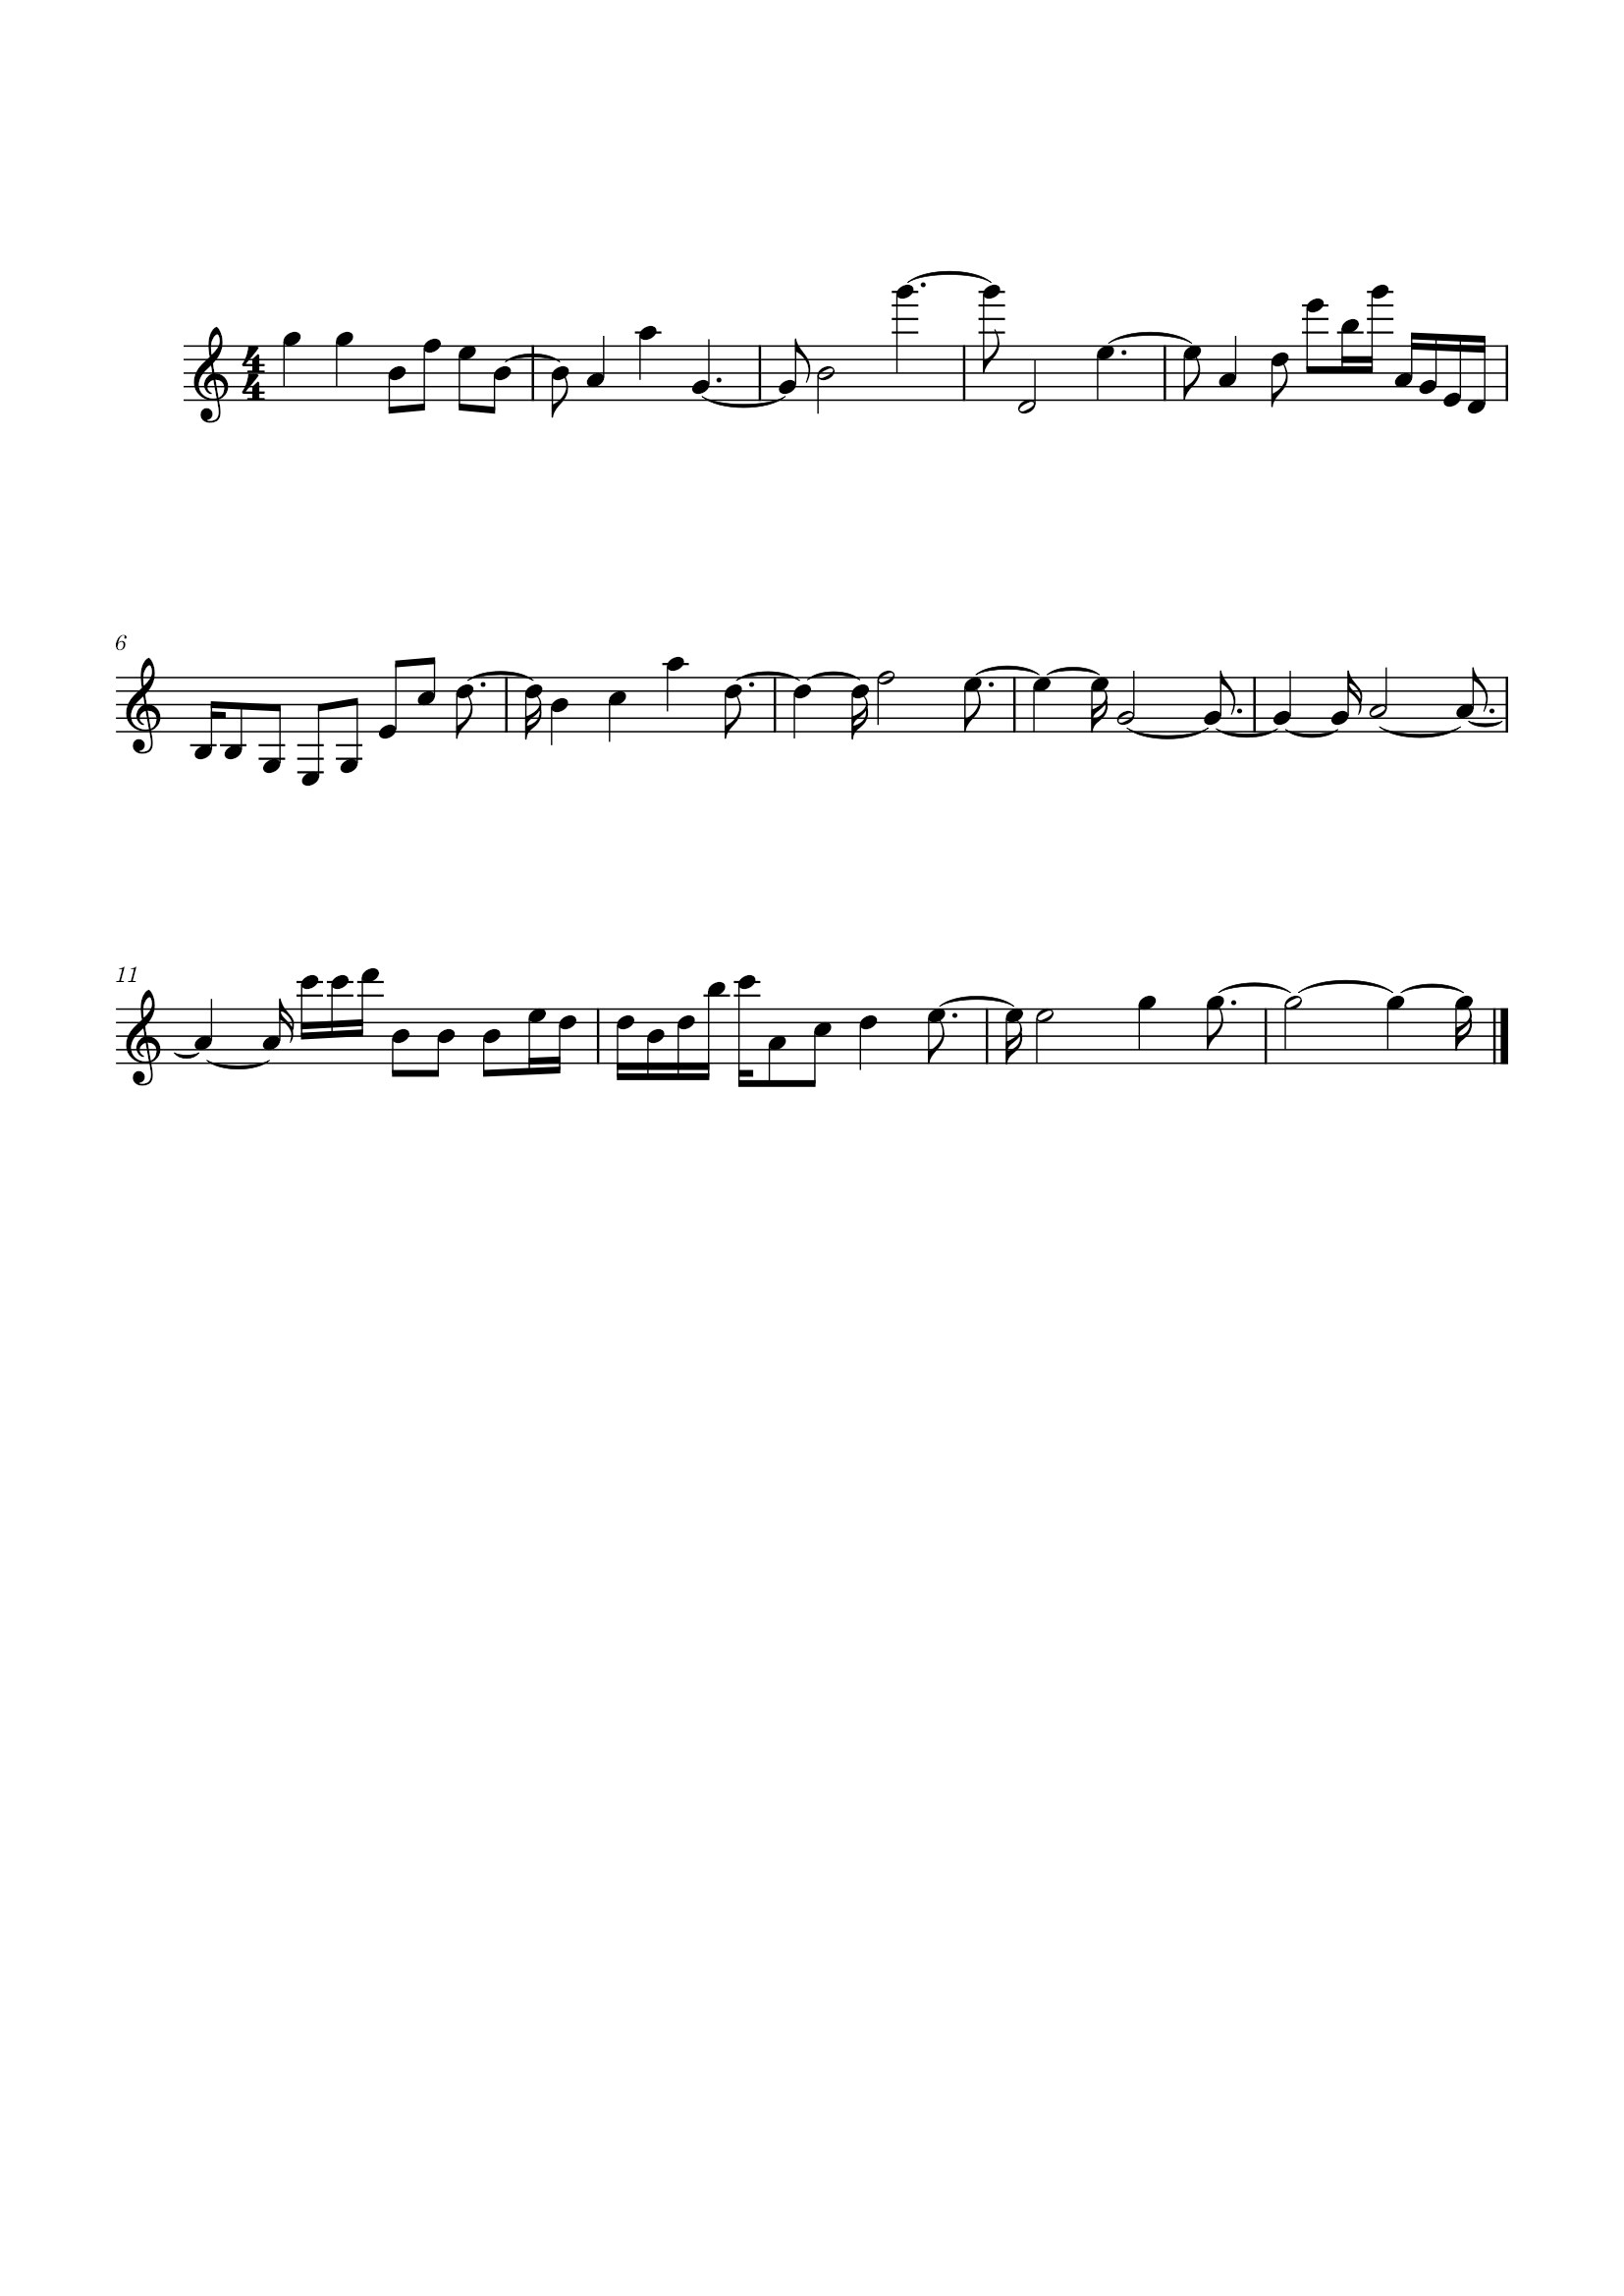

In [10]:
played_stream = stream.Stream(played_note)
played_stream.show()

In [ ]:
music_stream.write('lily.pdf', fp='my_generated_music101')